In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils.data import *
from utils.datetime import convert_to_pd_timestamp
from utils.maps import (location_map, zurich_map, penumbra_map, compactness_map,
                        xray_class_map, inverse_mapping)

from sklearn.svm import SVR
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

In [4]:
df_sunspot = pd.read_csv("../data/sunspot-processed.csv")
df_flares = pd.read_csv("../data/flares-processed.csv")

In [ ]:
df_flares['Start'] = pd.to_datetime(df_flares['Start'])
df_flares['End'] = pd.to_datetime(df_flares['End'])
df_flares['Maximum'] = pd.to_datetime(df_flares['Maximum'])

df_sunspot_no_null = df_sunspot.dropna(subset=['Region', 'Sunspot Number'])
df_flares_no_null = df_flares.dropna(subset=['Region', 'X-ray class', 'X-ray intensity'])

df_sunspot_no_null['Region'] = df_sunspot_no_null['Region'].astype(int)
df_flares_no_null['Region'] = df_flares_no_null['Region'].astype(int)

df_sunspot_no_null.to_csv("../data/sunspot-processed-nonull-R.csv", index=False)
df_flares_no_null.to_csv("../data/flares-processed-nonull-R.csv", index=False)

In [8]:
df_sunspot.shape, df_flares.shape

((138796, 10), (74580, 9))

In [220]:
get_null_counts(df_sunspot)

Region                2149
Sunspot Number       36505
Size                 50131
Zurich Class         36625
Penumbra Class       36687
Compactness Class    75774
dtype: int64

In [6]:
df_sunspot.dropna(subset=['Region', 'Sunspot Number'], inplace=True)
df_sunspot.shape

(137272, 10)

In [7]:
get_null_counts(df_flares)

Region             31450
X-ray class           16
X-ray intensity       19
dtype: int64

In [11]:
_tmp_df_sunspot = df_sunspot[['Year', 'Month', 'Day', 'Region']]
_tmp_df_sunspot['Date'] = pd.to_datetime(_tmp_df_sunspot[['Year', 'Month', 'Day']])
# _tmp_df_sunspot.set_index('Date', inplace=True)
# _tmp_df_sunspot['Region'] = _tmp_df_sunspot['Region'].replace(np.nan, -1)
_tmp_df_sunspot['Region'].isnull().sum()

/tmp/ipykernel_251178/1876020546.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _tmp_df_sunspot['Date'] = pd.to_datetime(_tmp_df_sunspot[['Year', 'Month', 'Day']])


0

In [12]:
_tmp_df_sunspot_day = (df_sunspot[['Year', 'Month', 'Day', 'Region', 'Sunspot Number']]
                    .groupby(['Year', 'Month', 'Day'])
                    .agg({'Sunspot Number': 'sum'})
                    .reset_index())

_tmp_df_sunspot_month = df_sunspot[['Year', 'Month', 'Region', 'Sunspot Number']]
_tmp_df_sunspot_month = (_tmp_df_sunspot_month
                    .groupby(['Year', 'Month'])
                    .agg({'Sunspot Number': 'sum'})
                    .reset_index())
_tmp_df_sunspot_month['Date'] = pd.to_datetime(_tmp_df_sunspot_month[['Year', 'Month']].assign(Day=1))
_tmp_df_sunspot_day.shape, _tmp_df_sunspot_month.shape

((12804, 4), (501, 4))

### Per day

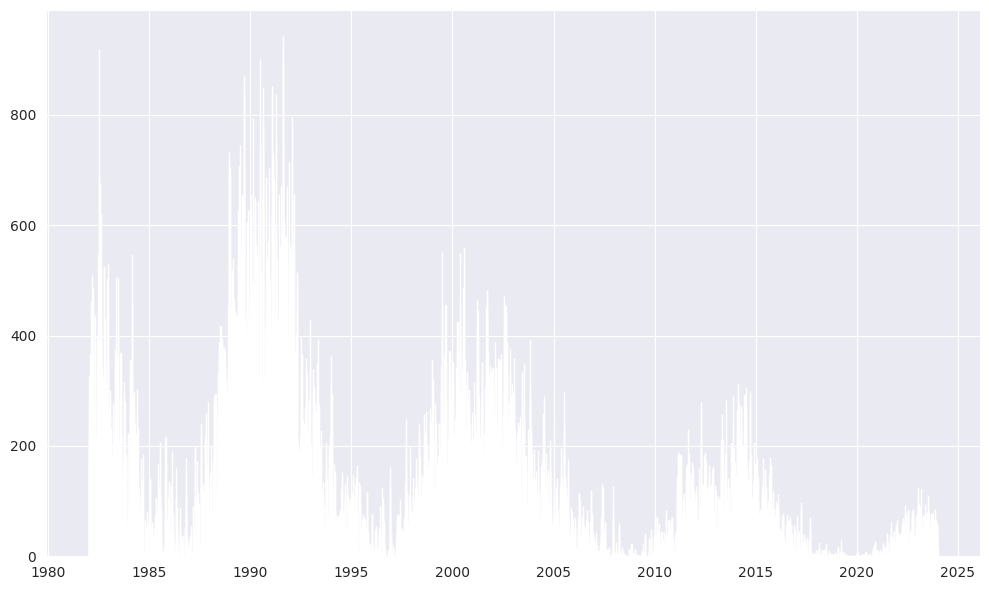

In [13]:
plt.figure(figsize=(10, 6))
plt.bar(pd.to_datetime(_tmp_df_sunspot_day[['Year', 'Month', 'Day']]),
         _tmp_df_sunspot_day['Sunspot Number'])
plt.tight_layout()

### per month

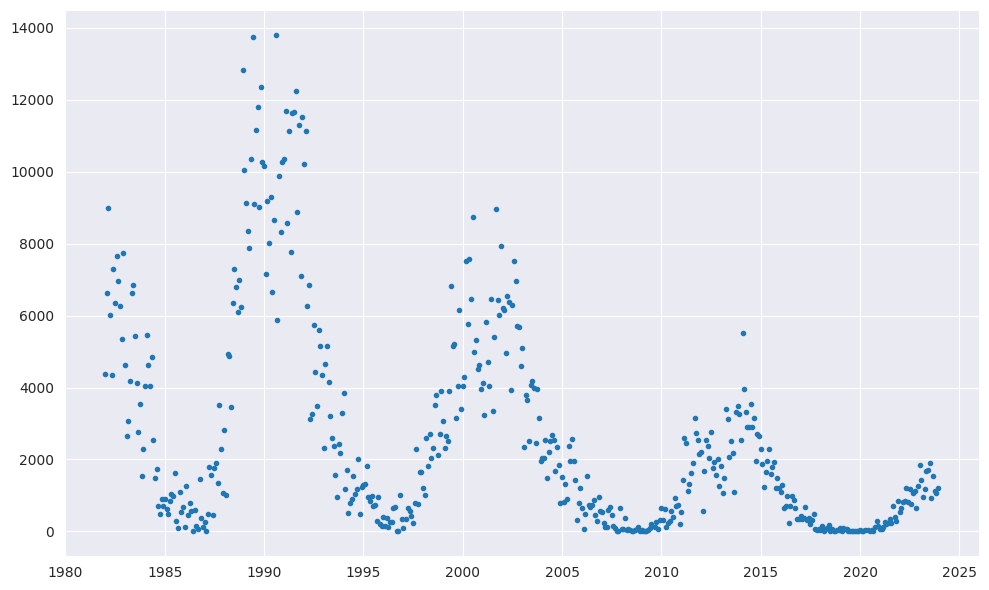

In [15]:
plt.figure(figsize=(10, 6))
plt.scatter(_tmp_df_sunspot_month['Date'],
         _tmp_df_sunspot_month['Sunspot Number'], marker='.')
plt.tight_layout()

### per year

In [16]:
_tmp_df_sunspot_year = (df_sunspot[['Year', 'Sunspot Number']]
                    .groupby(['Year'])
                    .agg({'Sunspot Number': 'sum'})
                    .reset_index())

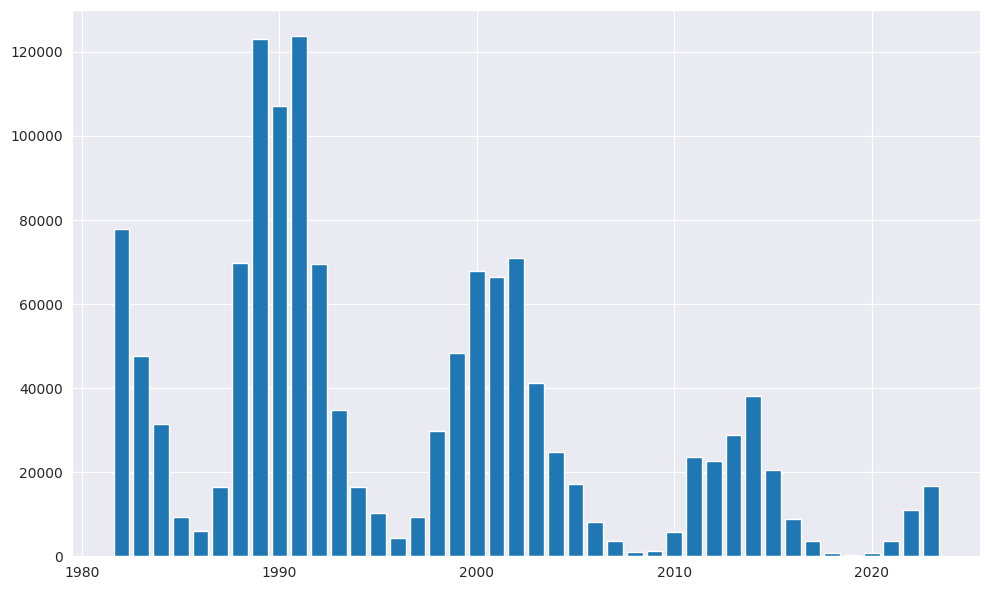

In [17]:
plt.figure(figsize=(10, 6))
plt.bar(_tmp_df_sunspot_year['Year'],
         _tmp_df_sunspot_year['Sunspot Number'])
plt.tight_layout()

## Full region

In [18]:
df_full_sunspot = pd.read_csv("../data/sunspot-processed-2.csv")
df_full_sunspot.dropna(subset=['Sunspot Number'], inplace=True)
_tmp_full_sunspot = df_full_sunspot[['Year', 'Month', 'Day']]

_tmp_full_sunspot_day = (df_full_sunspot[['Year', 'Month', 'Day', 'Sunspot Number']]
                    .groupby(['Year', 'Month', 'Day'])
                    .agg({'Sunspot Number': 'sum'})
                    .reset_index())

_tmp_full_sunspot_month = df_full_sunspot[['Year', 'Month', 'Sunspot Number']]
_tmp_full_sunspot_month = (_tmp_full_sunspot_month
                    .groupby(['Year', 'Month'])
                    .agg({'Sunspot Number': 'sum'})
                    .reset_index())
_tmp_full_sunspot_month['Date'] = pd.to_datetime(_tmp_df_sunspot_month[['Year', 'Month']].assign(Day=1))
_tmp_full_sunspot_year = (df_full_sunspot[['Year', 'Sunspot Number']]
                    .groupby(['Year'])
                    .agg({'Sunspot Number': 'sum'})
                    .reset_index())

In [19]:
_tmp_full_sunspot_year['Sunspot Number'].sum(), _tmp_df_sunspot_year['Sunspot Number'].sum()

(1326514.0, 1323143.0)

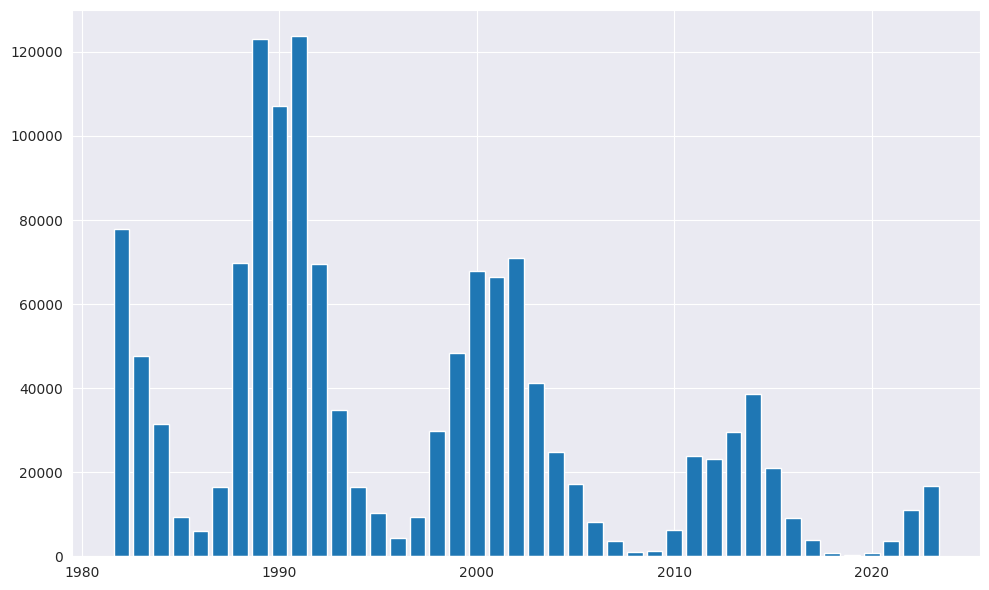

In [20]:
plt.figure(figsize=(10, 6))
plt.bar(_tmp_full_sunspot_year['Year'],
         _tmp_full_sunspot_year['Sunspot Number'])
plt.tight_layout()

## Flares

In [21]:
df_flares = df_flares.dropna(subset=['X-ray class', 'X-ray intensity'])
df_noR_flares = df_flares.dropna(subset=['Region'])
df_flares.shape, df_noR_flares.shape

((74561, 9), (43113, 9))

In [22]:
df_flares.groupby('Year').size().reset_index(name='Flares')

,Year,Flares
0,1982,3594
1,1983,2362
2,1984,2020
3,1985,1004
4,1986,853
5,1987,1324
6,1988,2291
7,1989,2548
8,1990,2539
9,1991,3210


In [23]:
(df_flares[['Year', 'Month', 'Day']]
                    .groupby(['Year', 'Month', 'Day'])
                    .size()
                    .reset_index(name='Flares'))

,Year,Month,Day,Flares
0,1982,1,1,7
1,1982,1,2,8
2,1982,1,3,5
3,1982,1,4,9
4,1982,1,5,2
...,...,...,...,...
11663,2023,12,27,4
11664,2023,12,28,4
11665,2023,12,29,10
11666,2023,12,30,8


In [24]:
_tmp_full_flares = df_flares[['Year', 'Month', 'Day']]

_tmp_full_flares_day = (_tmp_full_flares
                    .groupby(['Year', 'Month', 'Day'])
                    .size()
                    .reset_index(name='Flares'))

_tmp_full_flares_month = (_tmp_full_flares
                    .groupby(['Year', 'Month'])
                    .size()
                    .reset_index(name='Flares'))

# _tmp_full_sunspot_month['Date'] = pd.to_datetime(_tmp_df_sunspot_month[['Year', 'Month']].assign(Day=1))
_tmp_full_flares_year = (_tmp_full_flares[['Year']]
                    .groupby(['Year'])
                    .size()
                    .reset_index(name='Flares'))

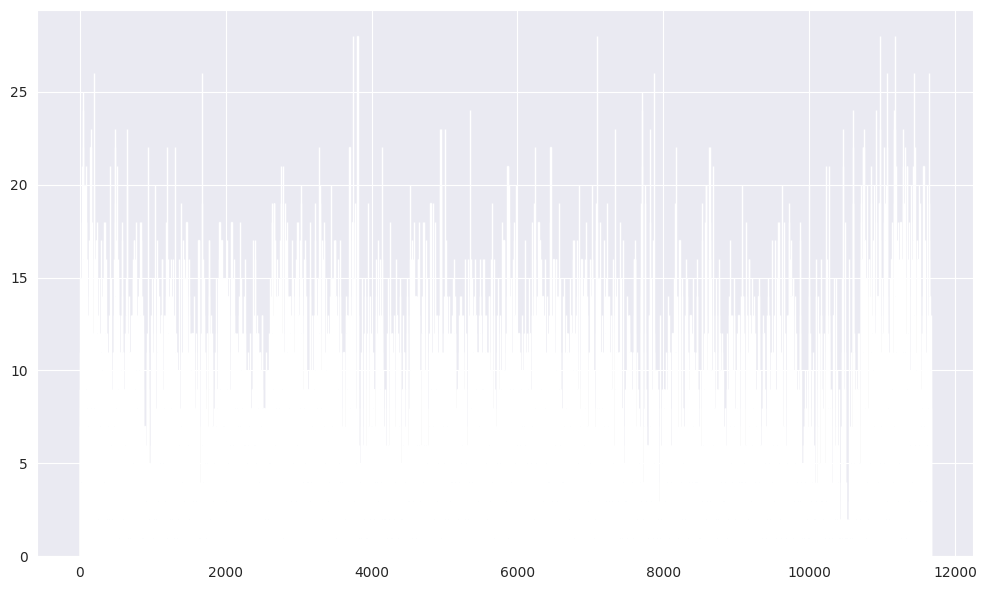

In [25]:
plt.figure(figsize=(10, 6))
plt.bar(_tmp_full_flares_day.index,
         _tmp_full_flares_day['Flares'])
plt.tight_layout()

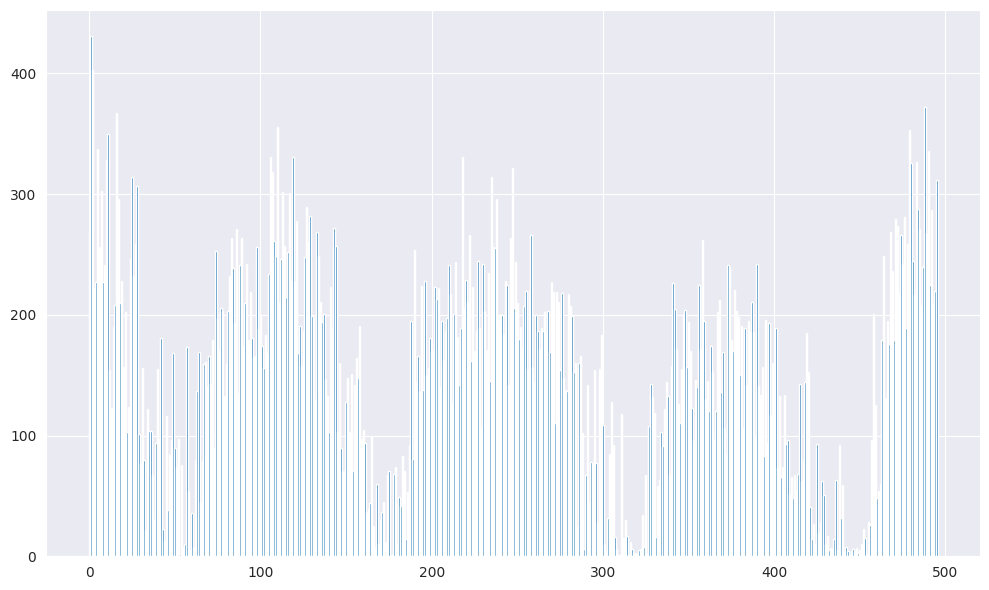

In [26]:
plt.figure(figsize=(10, 6))
plt.bar(_tmp_full_flares_month.index,
         _tmp_full_flares_month['Flares'])
plt.tight_layout()

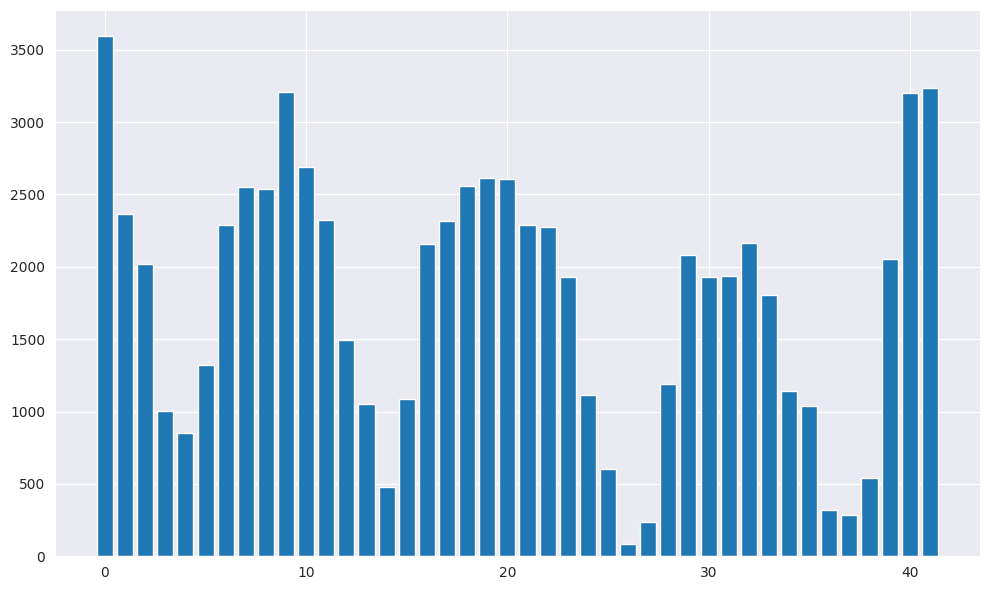

In [27]:
plt.figure(figsize=(10, 6))
plt.bar(_tmp_full_flares_year.index,
         _tmp_full_flares_year['Flares'])
plt.tight_layout()

## NO region

In [28]:
_tmp_noR_flares = df_flares[['Year', 'Month', 'Day', 'Region']]
_tmp_noR_flares = _tmp_noR_flares.dropna()
_tmp_noR_flares = _tmp_noR_flares[['Year', 'Month', 'Day']]

_tmp_noR_flares_day = (_tmp_noR_flares
                    .groupby(['Year', 'Month', 'Day'])
                    .size()
                    .reset_index(name='Flares'))

_tmp_noR_flares_month = (_tmp_noR_flares
                    .groupby(['Year', 'Month'])
                    .size()
                    .reset_index(name='Flares'))

_tmp_noR_flares_year = (_tmp_noR_flares[['Year']]
                    .groupby(['Year'])
                    .size()
                    .reset_index(name='Flares'))

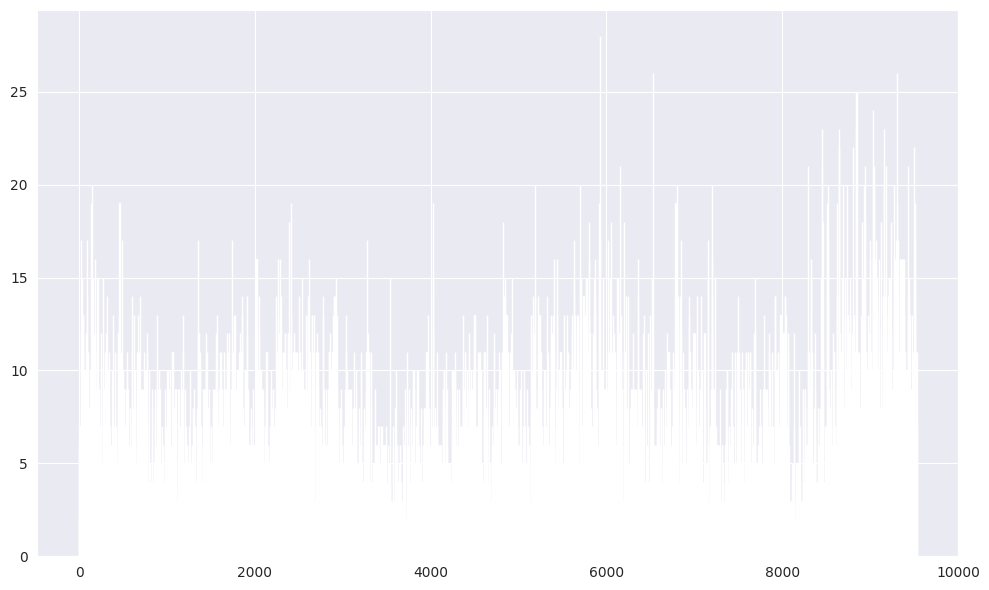

In [29]:
plt.figure(figsize=(10, 6))
plt.bar(_tmp_noR_flares_day.index,
         _tmp_noR_flares_day['Flares'])
plt.tight_layout()

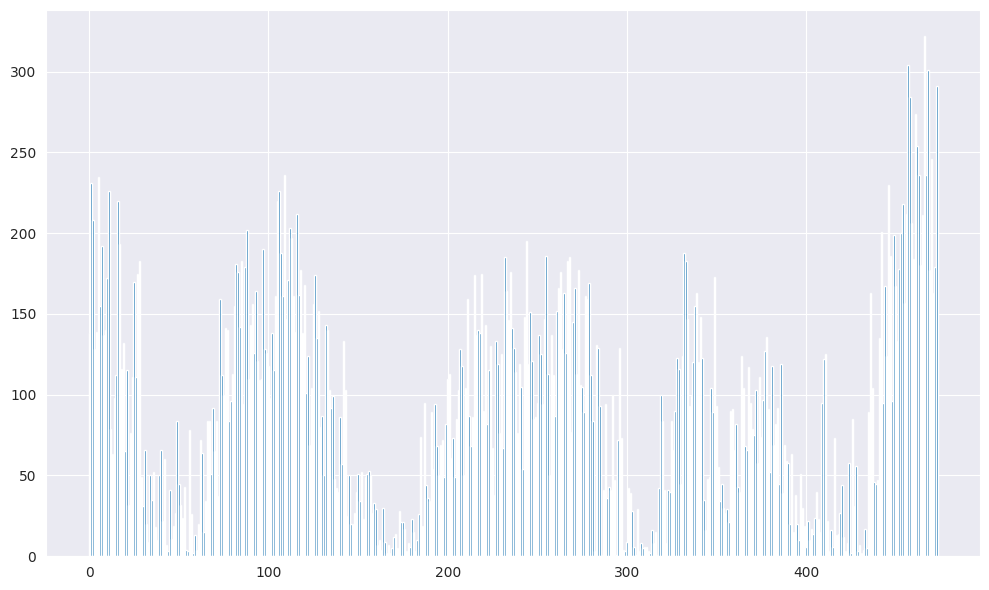

In [30]:
plt.figure(figsize=(10, 6))
plt.bar(_tmp_noR_flares_month.index,
         _tmp_noR_flares_month['Flares'])
plt.tight_layout()

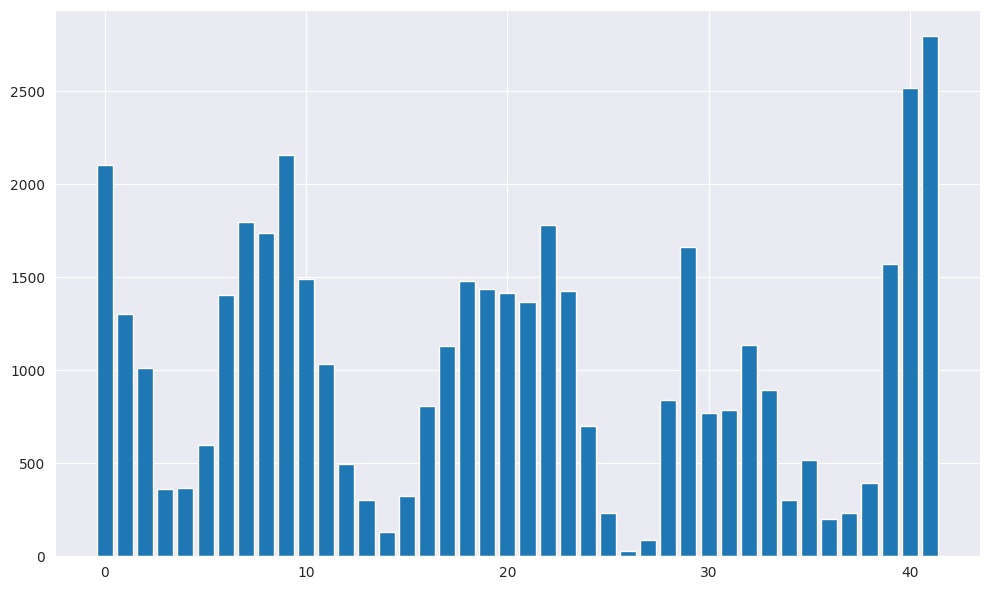

In [31]:
plt.figure(figsize=(10, 6))
plt.bar(_tmp_noR_flares_year.index,
         _tmp_noR_flares_year['Flares'])
plt.tight_layout()

# Interpolation

# ML interpolation result

In [32]:
df_sunspot['Region'] = df_sunspot['Region'].fillna(-1).astype(int)
df_flares['Region'] = df_flares['Region'].fillna(-1).astype(int)

# Merging

In [33]:
df_sunspot = pd.read_csv("../data/sunspot-processed-nonull-R.csv")

In [34]:
df_sunspot.head()

,Region,Sunspot Number,Size,Location,Year,Month,Day,Zurich Class,Penumbra Class,Compactness Class
0,3520,2.0,120.0,S22W72,1982,1,1,C,A,O
1,3520,4.0,330.0,S24W61,1982,1,1,C,H,O
2,3520,2.0,120.0,S24W72,1982,1,1,C,K,O
3,3520,6.0,160.0,S24W70,1982,1,1,C,S,O
4,3520,2.0,260.0,S24W62,1982,1,1,D,A,O


In [35]:
(sorted(df_sunspot['Zurich Class'].dropna().unique()),
 sorted(df_sunspot['Penumbra Class'].dropna().unique()),
 sorted(df_sunspot['Compactness Class'].dropna().unique()))

(['A', 'B', 'C', 'D', 'E', 'F', 'H'],
 ['A', 'H', 'K', 'R', 'S', 'X'],
 ['C', 'I', 'O', 'X'])

In [36]:
# Todo: commented for now
df_sunspot['Zurich Class'] = df_sunspot['Zurich Class'].map(zurich_map)
df_sunspot['Penumbra Class'] = df_sunspot['Penumbra Class'].map(penumbra_map)
df_sunspot['Compactness Class'] = df_sunspot['Compactness Class'].map(compactness_map)

# Location
df_sunspot[['NS', 'Lat', 'EW', 'Lan']] = (df_sunspot['Location']
                                          .str
                                          .extract(r'([A-Z])(\d+)([A-Z])(\d+)'))

# Todo: commented for now
# df_sunspot['NS'] = df_sunspot['NS'].map(location_map)
# df_sunspot['EW'] = df_sunspot['EW'].map(location_map)
df_sunspot.drop('Location', axis=1, inplace=True)

In [37]:
df_sunspot.drop('Region', axis=1)

,Sunspot Number,Size,Year,Month,Day,Zurich Class,Penumbra Class,Compactness Class,NS,Lat,EW,Lan
0,2.0,120.0,1982,1,1,3,4,2,S,22,W,72
1,4.0,330.0,1982,1,1,3,5,2,S,24,W,61
2,2.0,120.0,1982,1,1,3,6,2,S,24,W,72
3,6.0,160.0,1982,1,1,3,3,2,S,24,W,70
4,2.0,260.0,1982,1,1,4,4,2,S,24,W,62
...,...,...,...,...,...,...,...,...,...,...,...,...
137267,12.0,150.0,2023,12,30,4,4,2,S,13,E,16
137268,1.0,160.0,2023,12,31,7,3,1,S,19,W,77
137269,2.0,20.0,2023,12,31,2,1,2,N,15,W,78
137270,10.0,120.0,2023,12,31,4,4,2,S,12,E,03


In [38]:
df_sunspot_processed = df_sunspot.copy()

# Convert date to datetime format by combining Year, Month, and Day
df_sunspot_processed['Date'] = pd.to_datetime(df_sunspot_processed[['Year', 'Month', 'Day']])
df_sunspot_processed.drop(columns=['Year', 'Month', 'Day'], axis=1, inplace=True)

df_sunspot_processed['Size'].fillna(0, inplace=True)

_tmp_grouped = df_sunspot_processed.groupby(['Date', 'Region'])

# Group by date
df_sunspot_processed_grouped = _tmp_grouped.agg(
  sunspot_count=('Sunspot Number', 'sum'),
  max_size=('Size', 'max'),
  max_zurich_class=('Zurich Class', 'max'),
  max_penumbra_class=('Penumbra Class', 'max'),
  max_compactness_class=('Compactness Class', 'max')
).reset_index()

df_sunspot_processed_grouped.rename(
  columns={
    'sunspot_count': 'Total Sunspot',
    'max_size': 'Max Size',
    'max_zurich_class': 'Zurich Class',
    'max_penumbra_class': 'Penumbra Class',
    'max_compactness_class': 'Compactness Class',
  }, inplace=True)

# Merge the max size rows back to get the corresponding NS, Lat, EW, Lan
max_size_rows = df_sunspot_processed.loc[_tmp_grouped['Size'].idxmax()]

# Select relevant columns
max_size_rows = max_size_rows[['Date', 'NS', 'Lat', 'EW', 'Lan', 'Region']]
df_sunspot_processed_grouped = pd.merge(df_sunspot_processed_grouped, max_size_rows, on=['Date', 'Region'])
df_sunspot_processed_grouped

/tmp/ipykernel_251178/2391512664.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_sunspot_processed['Size'].fillna(0, inplace=True)


,Date,Region,Total Sunspot,Max Size,Zurich Class,Penumbra Class,Compactness Class,NS,Lat,EW,Lan
0,1982-01-01,3520,16.0,330.0,4,6,2,S,24,W,61
1,1982-01-01,3521,1.0,280.0,7,3,1,S,21,W,84
2,1982-01-01,3522,8.0,240.0,4,4,2,N,20,W,73
3,1982-01-01,3528,8.0,20.0,3,2,2,S,10,W,23
4,1982-01-01,3530,22.0,310.0,4,4,2,N,18,W,18
...,...,...,...,...,...,...,...,...,...,...,...
66116,2023-12-30,13534,12.0,150.0,4,4,2,S,13,E,16
66117,2023-12-31,13531,1.0,160.0,7,3,1,S,19,W,77
66118,2023-12-31,13533,2.0,20.0,2,1,2,N,15,W,78
66119,2023-12-31,13534,10.0,120.0,4,4,2,S,12,E,03


In [39]:
df_sunspot_processed_grouped.to_csv("../data/sunspot-grouped-by-region_date.csv", index=False)

## Flares

In [40]:
df_flares_no_null['Max log10 X-ray intensity'] = df_flares_no_null['X-ray class']\
                                  .map(xray_class_map) * df_flares_no_null['X-ray intensity']
df_flares_no_null['Max log10 X-ray intensity'] = df_flares_no_null['Max log10 X-ray intensity']\
                                  .apply(lambda _x: np.log10(_x) if _x != 0 else 0)

# df_flares_no_null.drop(['X-ray class', 'X-ray intensity'], axis=1, inplace=True)

In [41]:
df_flares_no_null['Date'] = pd.to_datetime(df_flares_no_null[['Year', 'Month', 'Day']])
df_flares_no_null.drop(columns=['Year', 'Month', 'Day'], axis=1, inplace=True)

df_flares_no_null['Duration'] = ((df_flares_no_null['End'] - df_flares_no_null['Start'])
                                 .dt.total_seconds())
df_flares_no_null['Duration'] = df_flares_no_null['Duration'].astype(int)
df_flares_no_null.drop(columns=['Start', 'End'], axis=1, inplace=True)

df_flares_no_null['Maximum'] = df_flares_no_null['Maximum'].apply(convert_to_pd_timestamp)

## Merge (no null region)

In [42]:
df_flares_no_null

,Region,X-ray class,X-ray intensity,Maximum,Max log10 X-ray intensity,Date,Duration
0,3522,M,3.1,378694860,-4.508638,1982-01-01,3360
1,3531,C,1.2,378707820,-5.920819,1982-01-01,1440
2,3531,C,2.1,378742860,-5.677781,1982-01-01,3240
3,3537,C,1.0,378750300,-6.000000,1982-01-01,480
5,3536,C,8.9,378767640,-5.050610,1982-01-01,540
...,...,...,...,...,...,...,...
74575,13536,C,5.5,1704027300,-5.259637,2023-12-31,2220
74576,13536,C,3.8,1704046560,-5.420216,2023-12-31,1560
74577,13536,C,4.2,1704047940,-5.376751,2023-12-31,960
74578,13536,M,1.0,1704049920,-5.000000,2023-12-31,3360


In [43]:
df_flares_processed_grouped = (df_flares_no_null
                               .groupby(['Date', 'Region'])
                               .agg({'Region': 'count',
                                     'Maximum': ['mean'],
                                     'Max log10 X-ray intensity': 'max',
                                     'Duration': [('Max', 'max'), ('Avg', 'mean')],
                                     })
                               .rename(columns={'count': 'count'})
                               .reset_index())


df_flares_processed_grouped.columns = [' '.join(col).strip() for col in df_flares_processed_grouped.columns.values]

df_flares_processed_grouped = df_flares_processed_grouped.rename(
  columns={'Region count': 'Flares Count',
  'Maximum mean': 'Avg Max Time',
  'Max log10 X-ray intensity max': 'Max log10 X-ray intensity',
  'Duration Max': 'Max Duration',
  'Duration Avg': 'Avg Duration'})

# picking 'X-ray class' & 'X-ray intensity' where max log10 X-ray intensity
df_flares_processed_grouped = pd.merge(df_flares_processed_grouped,
                  df_flares_no_null[['Date', 'Region', 'Max log10 X-ray intensity',
                                     'X-ray class', 'X-ray intensity']],
                  on=['Date', 'Region', 'Max log10 X-ray intensity'], how='left')

df_flares_processed_grouped

,Date,Region,Flares Count,Avg Max Time,Max log10 X-ray intensity,Max Duration,Avg Duration,X-ray class,X-ray intensity
0,1982-01-01,3522,2,3.787330e+08,-4.508638,3360,2340.000000,M,3.1
1,1982-01-01,3531,2,3.787253e+08,-5.677781,3240,2340.000000,C,2.1
2,1982-01-01,3536,1,3.787676e+08,-5.050610,540,540.000000,C,8.9
3,1982-01-01,3537,1,3.787503e+08,-6.000000,480,480.000000,C,1.0
4,1982-01-02,3522,1,3.788004e+08,-4.091515,1680,1680.000000,M,8.1
...,...,...,...,...,...,...,...,...,...
17977,2023-12-30,13530,6,1.703943e+09,-5.214670,1680,880.000000,C,6.1
17978,2023-12-30,13534,1,1.703920e+09,-5.721246,1800,1800.000000,C,1.9
17979,2023-12-31,10353,1,1.703982e+09,-5.677781,600,600.000000,C,2.1
17980,2023-12-31,13531,1,1.703991e+09,-5.920819,1560,1560.000000,C,1.2


In [44]:
df_flares_processed_grouped.to_csv("../data/flares-grouped-by-region_date.csv", index=False)

# Final merge (non-null Region)

In [51]:
df_sunspot_processed_grouped.shape, df_flares_processed_grouped.shape

((66121, 11), (17982, 9))

In [52]:
df_sunspot_processed_grouped = df_sunspot_processed_grouped[
  df_sunspot_processed_grouped['Region'] > 3e3]
df_flares_processed_grouped = df_flares_processed_grouped[
  df_flares_processed_grouped['Region'] > 3e3]

df_sunspot_processed_grouped.shape, df_flares_processed_grouped.shape

((66118, 11), (17976, 9))

In [53]:
# Apply the inverse mapping
df_sunspot_processed_grouped['Zurich Class'] = (df_sunspot_processed_grouped['Zurich Class']
                                                .map(inverse_mapping(zurich_map)))
df_sunspot_processed_grouped['Penumbra Class'] = (df_sunspot_processed_grouped['Penumbra Class']
                                                .map(inverse_mapping(penumbra_map)))
df_sunspot_processed_grouped['Compactness Class'] = (df_sunspot_processed_grouped['Compactness Class']
                                                .map(inverse_mapping(compactness_map)))

/tmp/ipykernel_251178/1412637763.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sunspot_processed_grouped['Zurich Class'] = (df_sunspot_processed_grouped['Zurich Class']
/tmp/ipykernel_251178/1412637763.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sunspot_processed_grouped['Penumbra Class'] = (df_sunspot_processed_grouped['Penumbra Class']
/tmp/ipykernel_251178/1412637763.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

In [54]:
merged_df = pd.merge(df_sunspot_processed_grouped, df_flares_processed_grouped, on=['Date', 'Region'], how='left')
merged_df.fillna(0, inplace=True)
merged_df.shape

(66118, 18)

In [56]:
merged_df.drop('Region', axis=1, inplace=True)
merged_df

,Date,Total Sunspot,Max Size,Zurich Class,Penumbra Class,Compactness Class,NS,Lat,EW,Lan,Flares Count,Avg Max Time,Max log10 X-ray intensity,Max Duration,Avg Duration,X-ray class,X-ray intensity
0,1982-01-01,16.0,330.0,D,K,O,S,24,W,61,0.0,0.000000e+00,0.000000,0.0,0.000000,0,0.0
1,1982-01-01,1.0,280.0,H,S,X,S,21,W,84,0.0,0.000000e+00,0.000000,0.0,0.000000,0,0.0
2,1982-01-01,8.0,240.0,D,A,O,N,20,W,73,2.0,3.787330e+08,-4.508638,3360.0,2340.000000,M,3.1
3,1982-01-01,8.0,20.0,C,R,O,S,10,W,23,0.0,0.000000e+00,0.000000,0.0,0.000000,0,0.0
4,1982-01-01,22.0,310.0,D,A,O,N,18,W,18,0.0,0.000000e+00,0.000000,0.0,0.000000,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66113,2023-12-30,12.0,150.0,D,A,O,S,13,E,16,1.0,1.703920e+09,-5.721246,1800.0,1800.000000,C,1.9
66114,2023-12-31,1.0,160.0,H,S,X,S,19,W,77,1.0,1.703991e+09,-5.920819,1560.0,1560.000000,C,1.2
66115,2023-12-31,2.0,20.0,B,X,O,N,15,W,78,0.0,0.000000e+00,0.000000,0.0,0.000000,0,0.0
66116,2023-12-31,10.0,120.0,D,A,O,S,12,E,03,0.0,0.000000e+00,0.000000,0.0,0.000000,0,0.0


In [57]:
# converting 0 (int) to string
merged_df['X-ray class'] = merged_df['X-ray class'].astype(str)
merged_df['Zurich Class'] = merged_df['Zurich Class'].astype(str)
merged_df['Penumbra Class'] = merged_df['Penumbra Class'].astype(str)
merged_df['Compactness Class'] = merged_df['Compactness Class'].astype(str)

# slight modification

In [14]:
merged_df = merged_df.drop(columns=["Avg Max Time", "Flares Count",
                                        "Max log10 X-ray intensity",
                                        "Max Duration", "Avg Duration"],
                               axis=1)
merged_df.to_csv("../data/final-sunspot-merged.csv", index=False)
merged_df.shape

(66118, 12)